# Benchmarking RDF against MDAnalysis
The algorithms in freud are highly efficient and rely on parallelized C++ code. Below, we show a benchmark of `freud.density.RDF` against `MDAnalysis.analysis.rdf`. This benchmark was run on an Intel(R) Core(TM) i3-8100B CPU @ 3.60GHz.

In [1]:
import freud
import gsd
import MDAnalysis
import MDAnalysis.analysis.rdf
import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt
import timeit
from tqdm import tqdm

In [2]:
trajectory_filename = 'data/rdf_benchmark.gsd'
r_max = 5
r_min = 0.1
nbins = 75

In [3]:
trajectory = MDAnalysis.coordinates.GSD.GSDReader(trajectory_filename)
frame = trajectory[0]
topology = MDAnalysis.core.topology.Topology(n_atoms=frame.n_atoms)
u = MDAnalysis.as_Universe(topology, trajectory_filename)

rdf = MDAnalysis.analysis.rdf.InterRDF(g1=u.atoms, g2=u.atoms,
                                       nbins=nbins,
                                       range=(r_min, r_max)).run()

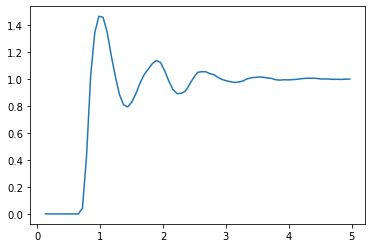

In [4]:
plt.plot(rdf.bins, rdf.rdf)
plt.show()

In [5]:
with gsd.hoomd.open(trajectory_filename, 'rb') as traj:
    freud_rdf = freud.density.RDF(nbins, r_max=r_max, r_min=r_min)
    for frame in traj:
        freud_rdf.compute((frame.configuration.box, frame.particles.position), reset=False)

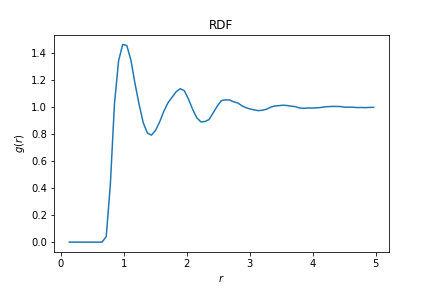

In [6]:
freud_rdf

## Timing Functions

In [7]:
def time_statement(stmt, repeat=3, number=1, **kwargs):
    timer = timeit.Timer(stmt=stmt, globals=kwargs)
    times = timer.repeat(repeat, number)
    return np.mean(times), np.std(times)

In [8]:
def time_freud_rdf(trajectory_filename, r_max, r_min, nbins):
    code = """
rdf = freud.density.RDF(nbins, r_max=r_max, r_min=r_min)
for frame in trajectory:
    rdf.compute((frame.configuration.box, frame.particles.position), reset=False)"""
    with gsd.hoomd.open(trajectory_filename, 'rb') as trajectory:
        return time_statement(code, freud=freud, trajectory=trajectory, r_max=r_max, r_min=r_min, nbins=nbins)

In [9]:
def time_mdanalysis_rdf(trajectory_filename, r_max, r_min, nbins):
    trajectory = MDAnalysis.coordinates.GSD.GSDReader(trajectory_filename)
    frame = trajectory[0]
    topology = MDAnalysis.core.topology.Topology(n_atoms=frame.n_atoms)
    u = MDAnalysis.as_Universe(topology, trajectory_filename)
    code = """rdf = MDAnalysis.analysis.rdf.InterRDF(g1=u.atoms, g2=u.atoms, nbins=nbins, range=(r_min, r_max)).run()"""
    return time_statement(code, MDAnalysis=MDAnalysis, u=u, r_max=r_max, r_min=r_min, nbins=nbins)

In [10]:
# Test timing functions
params = dict(
    trajectory_filename=trajectory_filename,
    r_max=r_max,
    r_min=r_min,
    nbins=nbins)

def system_size(trajectory_filename, **kwargs):
    with gsd.hoomd.open(params['trajectory_filename'], 'rb') as trajectory:
        return {'frames': len(trajectory),
                'particles': len(trajectory[0].particles.position)}

print(system_size(**params))
freud_rdf_runtime = time_freud_rdf(**params)
print('freud:', freud_rdf_runtime)
mdanalysis_rdf_runtime = time_mdanalysis_rdf(**params)
print('MDAnalysis:', mdanalysis_rdf_runtime)

{'frames': 5, 'particles': 15625}
freud: (2.7189949636666655, 0.04705492129814755)
MDAnalysis: (17.26371042166667, 0.09559454797781862)


## Perform Measurements

In [11]:
def measure_runtime_scaling_r_max(r_maxes, **params):
    result_times = []
    for r_max in tqdm(r_maxes):
        params.update(dict(r_max=r_max))
        freud.parallel.set_num_threads(1)
        freud_single = time_freud_rdf(**params)
        freud.parallel.set_num_threads(0)
        result_times.append((freud_single, time_freud_rdf(**params), time_mdanalysis_rdf(**params)))
    return np.asarray(result_times)

In [12]:
def plot_result_times(result_times, r_maxs, frames, particles):
    plt.figure(figsize=(6, 4), dpi=200)
    plt.errorbar(r_maxs, result_times[:, 0, 0], result_times[:, 0, 1],
                 label="freud v{} density.RDF P=1".format(freud.__version__))
    plt.errorbar(r_maxs, result_times[:, 1, 0], result_times[:, 1, 1],
                 label="freud v{} density.RDF P={}".format(freud.__version__, mp.cpu_count()))
    plt.errorbar(r_maxs, result_times[:, 2, 0], result_times[:, 2, 1],
                 label="MDAnalysis v{} analysis.rdf.InterRDF".format(MDAnalysis.__version__))
    plt.title(r'RDF for {} frames, {} particles'.format(frames, particles))
    plt.xlabel(r'RDF $r_{{max}}$')
    plt.ylabel(r'Average Runtime (s)')
    plt.yscale('log')
    plt.legend()
    plt.show()

In [13]:
r_maxes = [0.2, 0.3, 0.5, 1, 2, 3]

100%|██████████| 6/6 [00:30<00:00,  5.12s/it]


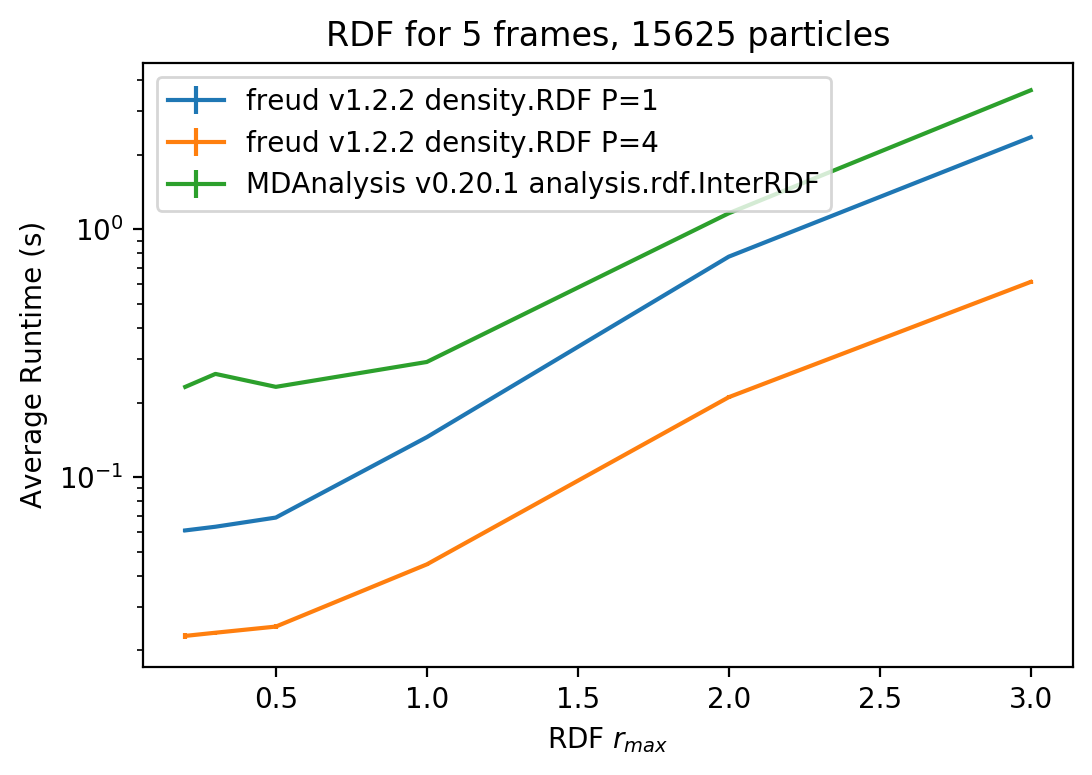

In [14]:
result_times = measure_runtime_scaling_r_max(r_maxes, **params)
plot_result_times(result_times, r_maxes, **system_size(params['trajectory_filename']))

In [15]:
print('Speedup, parallel freud / serial freud: {:.3f}x'.format(np.average(result_times[:, 0, 0] / result_times[:, 1, 0])))
print('Speedup, parallel freud / MDAnalysis: {:.3f}x'.format(np.average(result_times[:, 2, 0] / result_times[:, 1, 0])))
print('Speedup, serial freud / MDAnalysis: {:.3f}x'.format(np.average(result_times[:, 2, 0] / result_times[:, 0, 0])))

Speedup, parallel freud / serial freud: 3.146x
Speedup, parallel freud / MDAnalysis: 8.078x
Speedup, serial freud / MDAnalysis: 2.726x
